# Loading the Data
We will start first by loading and preparing our data
---

In [ ]:
# import and all essentials for the report

import numpy as np 
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display
import re
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional

In [ ]:
# File list 
list_of_files = [
    'Protocol/subject101.dat',
    'Protocol/subject102.dat',
    'Protocol/subject103.dat',
    'Protocol/subject104.dat',
    'Protocol/subject105.dat',
    'Protocol/subject106.dat',
    'Protocol/subject107.dat',
    'Protocol/subject108.dat',
    'Protocol/subject109.dat'
]

# Activity mapping
activityIDdict = {
    0: 'transient', 1: 'lying', 2: 'sitting', 3: 'standing', 4: 'walking',
    5: 'running', 6: 'cycling', 7: 'Nordic_walking', 9: 'watching_TV',
    10: 'computer_work', 11: 'car driving', 12: 'ascending_stairs',
    13: 'descending_stairs', 16: 'vacuum_cleaning', 17: 'ironing',
    18: 'folding_laundry', 19: 'house_cleaning', 20: 'playing_soccer',
    24: 'rope_jumping'
}

# Sensor columns
colNames = ["timestamp", "activityID", "heartrate"]

IMUhand = ['handTemperature', 'handAcc16_1', 'handAcc16_2', 'handAcc16_3',
           'handAcc6_1', 'handAcc6_2', 'handAcc6_3',
           'handGyro1', 'handGyro2', 'handGyro3',
           'handMagne1', 'handMagne2', 'handMagne3',
           'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']

IMUchest = ['chestTemperature', 'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3',
            'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3',
            'chestGyro1', 'chestGyro2', 'chestGyro3',
            'chestMagne1', 'chestMagne2', 'chestMagne3',
            'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']

IMUankle = ['ankleTemperature', 'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3',
            'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3',
            'ankleGyro1', 'ankleGyro2', 'ankleGyro3',
            'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
            'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']

columns = colNames + IMUhand + IMUchest + IMUankle


In [4]:
# Load data efficiently
data_list = []

for file in list_of_files:
    try:
        subject = pd.read_table(file, header=None, sep=r'\s+')
        subject.columns = columns

        # Extract subject ID from filename (e.g., 101 from 'subject101.dat')
        subject_id = int(re.search(r'\d+', file).group())
        subject['subject_id'] = subject_id

        data_list.append(subject)
        print(f"Loaded {file}")

    except FileNotFoundError:
        print(f"File not found: {file}")
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Combine all into one DataFrame
data_pamap2 = pd.concat(data_list, ignore_index=True)
print(f"\nTotal rows loaded: {len(data_pamap2)}")


Loaded Protocol/subject101.dat
Loaded Protocol/subject102.dat
Loaded Protocol/subject103.dat
Loaded Protocol/subject104.dat
Loaded Protocol/subject105.dat
Loaded Protocol/subject106.dat
Loaded Protocol/subject107.dat
Loaded Protocol/subject108.dat
Loaded Protocol/subject109.dat

Total rows loaded: 2872533


# Data Exploration

Before we start to examine the loaded data we will the start by presanting an overview on the data.<br> if we want a full overview, we can check out the provided PDF's.

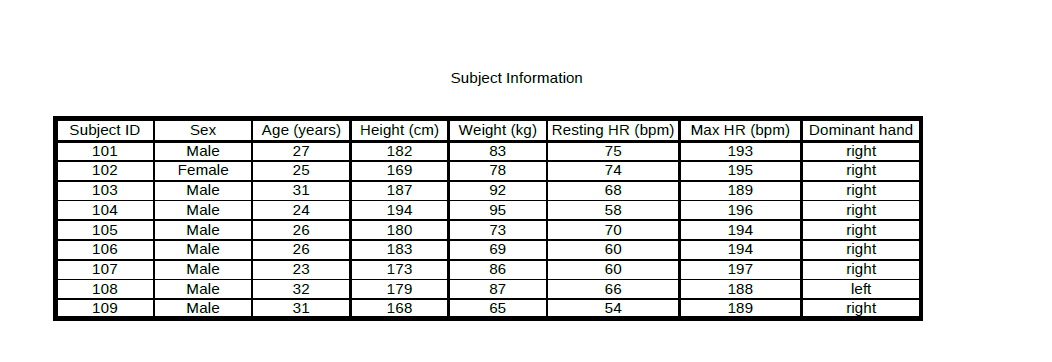

We can see clearly from the picture above that the age of the subjects varies between 24-32.<br> also note that there are 8 males and only 1 female tested.

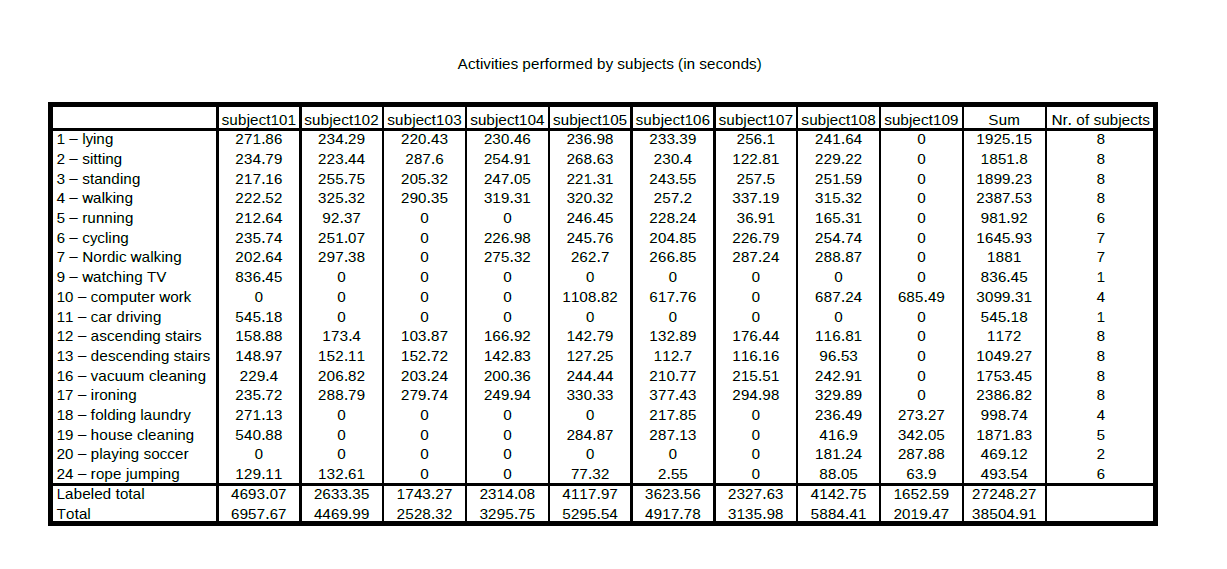

As it seen from the picture above, most of the data is going be balanced,<br>i.e. most of the task were performed in the same amount of time and with mostly even distribution across the range of subjects.<br><br>Note that **subject 109** performed the least amount of activities, this is a notion we need to refer while testing the model's, we don't want only him to represant our testing data.

In [7]:
display(data_pamap2.head())

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0,101
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0,101
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0,101
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0,101
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0,101


It can be seen from the sample of the loaded data that some **data cleaning** is required.
For example the activityID 0 must be removed completely from the dataset because it is represanting a transient state(see the readme.pdf for more information).

## Data Cleaning
---

From the given file **PerformedActivitiesSummary** we can see that few of the data is missing, due to wireless disconnections for example.<br>
We chose also to remove the body orientation, because it seems to us irrelavnat and will take the model more time to train.<br><br> The easiest way to remove the NaN values is to use interpolation, we will start by removing the irrelavant values and then interpolate between the unkown values.




In [8]:
def clean_data(data):
    # removing data with transient activity
    data = data.drop(data[data['activityID']==0].index)
    # remove non-numeric data cells
    data = data.apply(pd.to_numeric, errors = 'coerce')
    # removing NaN values using iterpolation
    data = data.interpolate()
    return data
    

In [9]:
data_clean = clean_data(data_pamap2)
data_clean.reset_index(drop=True,inplace=True)
display(data_clean.head(15))

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
0,37.66,1,NaN,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,...,-0.027714,0.001752,-61.1081,-36.8636,-58.3696,1.0,0.0,0.0,0.0,101
1,37.67,1,NaN,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,...,0.000945,0.006007,-60.8916,-36.3197,-58.3656,1.0,0.0,0.0,0.0,101
2,37.68,1,NaN,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,...,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119,1.0,0.0,0.0,0.0,101
3,37.69,1,NaN,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,...,-0.018844,0.026950,-60.7646,-37.1028,-57.8799,1.0,0.0,0.0,0.0,101
4,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,...,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847,1.0,0.0,0.0,0.0,101
5,37.71,1,100.0,30.375,2.07165,7.25965,6.01218,2.19238,7.21038,6.01604,...,-0.026906,0.004125,-61.3257,-36.9744,-57.7501,1.0,0.0,0.0,0.0,101
6,37.72,1,100.0,30.375,2.41148,7.59780,5.93915,2.23988,7.46679,6.03053,...,-0.032277,-0.006866,-61.5520,-36.9632,-57.9957,1.0,0.0,0.0,0.0,101
7,37.73,1,100.0,30.375,2.32815,7.63431,5.70686,2.31663,7.64745,6.01495,...,-0.016621,0.006548,-61.5738,-36.1724,-59.3487,1.0,0.0,0.0,0.0,101
8,37.74,1,100.0,30.375,2.25096,7.78598,5.62821,2.28637,7.70801,5.93935,...,0.020393,-0.011880,-61.7741,-37.1744,-58.1199,1.0,0.0,0.0,0.0,101
9,37.75,1,100.0,30.375,2.14107,7.52262,5.78141,2.31538,7.72276,5.78828,...,-0.010763,0.005133,-60.7680,-37.4206,-58.8735,1.0,0.0,0.0,0.0,101


In [10]:
print(data_clean.isnull().sum())

timestamp            0
activityID           0
heartrate            4
handTemperature      0
handAcc16_1          0
handAcc16_2          0
handAcc16_3          0
handAcc6_1           0
handAcc6_2           0
handAcc6_3           0
handGyro1            0
handGyro2            0
handGyro3            0
handMagne1           0
handMagne2           0
handMagne3           0
handOrientation1     0
handOrientation2     0
handOrientation3     0
handOrientation4     0
chestTemperature     0
chestAcc16_1         0
chestAcc16_2         0
chestAcc16_3         0
chestAcc6_1          0
chestAcc6_2          0
chestAcc6_3          0
chestGyro1           0
chestGyro2           0
chestGyro3           0
chestMagne1          0
chestMagne2          0
chestMagne3          0
chestOrientation1    0
chestOrientation2    0
chestOrientation3    0
chestOrientation4    0
ankleTemperature     0
ankleAcc16_1         0
ankleAcc16_2         0
ankleAcc16_3         0
ankleAcc6_1          0
ankleAcc6_2          0
ankleAcc6_3

As we can see there are still 4 more values of NaN for the heart rate for the first subject,<br>this is due the notion that the first 4 values were NaN so the interpolation uses these values.<br><br>As it can be seen the heart rate for this subject is 100.0 for at least 10 more timelapses, so we will assumes that the 4 values are also 100.0 since heart rate don't change rapidly, also note that the activity performed by the subject is 'lying' which makes our assumption more realistic.

In [11]:
data_clean.loc[0:3, 'heartrate'] = 100.0
print(data_clean.isnull().sum())


timestamp            0
activityID           0
heartrate            0
handTemperature      0
handAcc16_1          0
handAcc16_2          0
handAcc16_3          0
handAcc6_1           0
handAcc6_2           0
handAcc6_3           0
handGyro1            0
handGyro2            0
handGyro3            0
handMagne1           0
handMagne2           0
handMagne3           0
handOrientation1     0
handOrientation2     0
handOrientation3     0
handOrientation4     0
chestTemperature     0
chestAcc16_1         0
chestAcc16_2         0
chestAcc16_3         0
chestAcc6_1          0
chestAcc6_2          0
chestAcc6_3          0
chestGyro1           0
chestGyro2           0
chestGyro3           0
chestMagne1          0
chestMagne2          0
chestMagne3          0
chestOrientation1    0
chestOrientation2    0
chestOrientation3    0
chestOrientation4    0
ankleTemperature     0
ankleAcc16_1         0
ankleAcc16_2         0
ankleAcc16_3         0
ankleAcc6_1          0
ankleAcc6_2          0
ankleAcc6_3

### Data Distribution
---

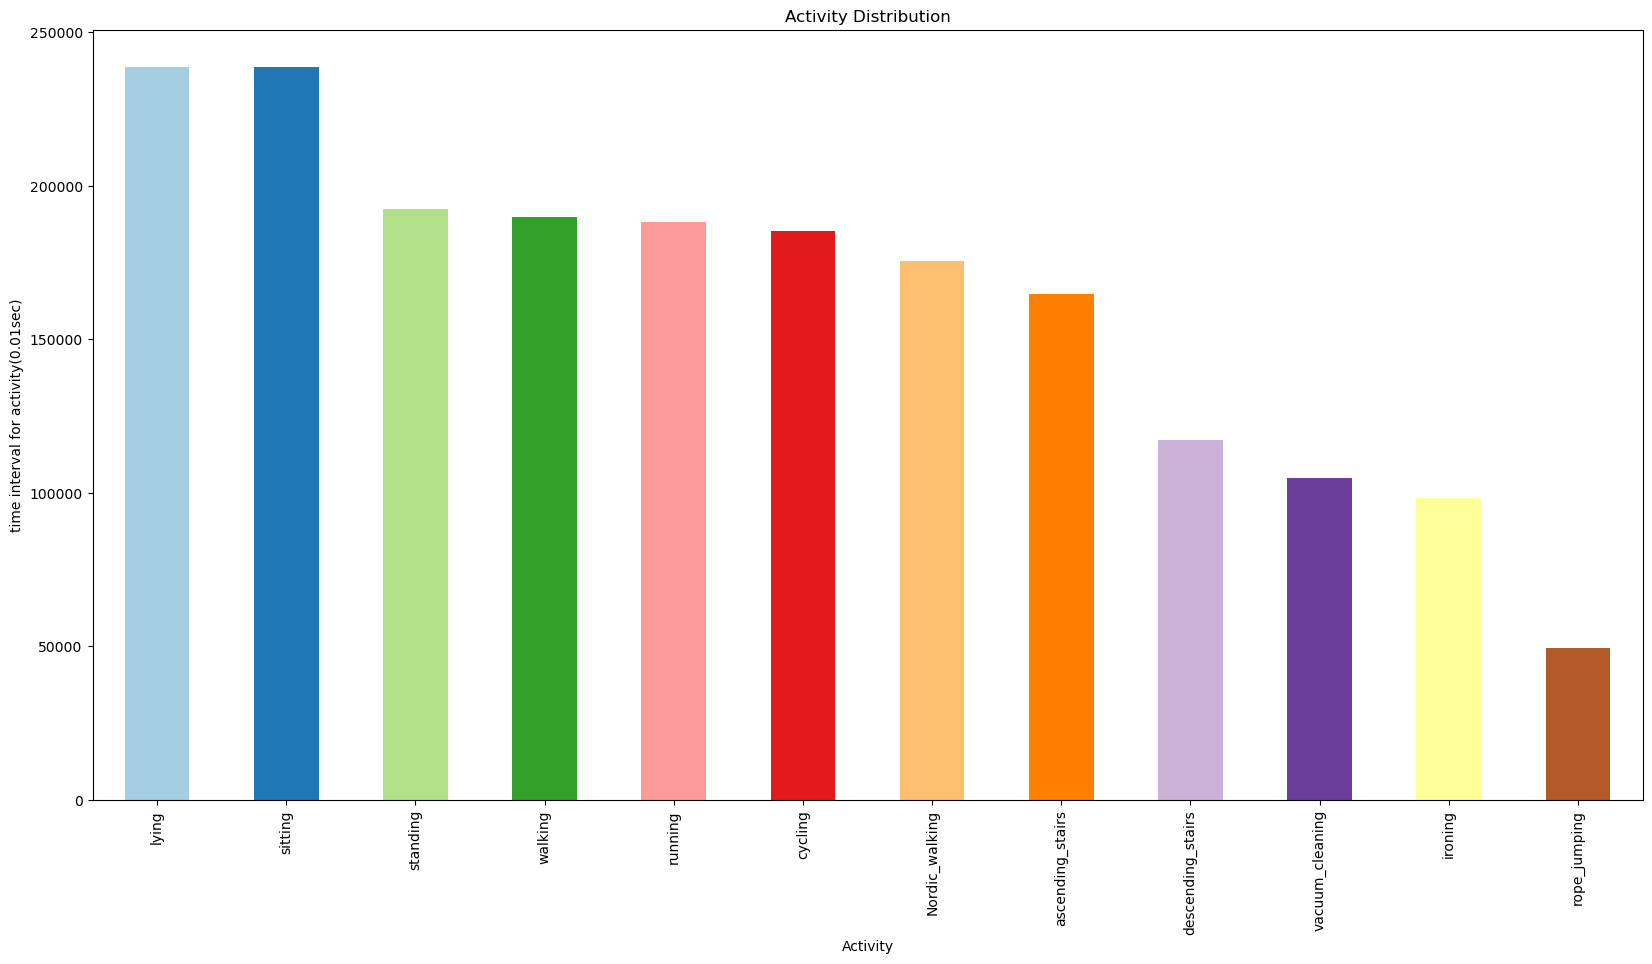

In [12]:
data_clean_copy = data_clean
plt.figure()
# activity distribution
N = len(np.unique(data_clean_copy['activityID']))
xticks = np.arange(12)
xticks_lbl = [activityIDdict[x] for x in  np.unique(data_clean_copy['activityID']).tolist()]
data_clean_copy['activityID'].value_counts().plot(kind="bar", figsize=(20,10), color=plt.cm.Paired(np.arange(N)))
plt.xticks(ticks=xticks,labels=xticks_lbl)
plt.title("Activity Distribution")
plt.xlabel('Activity')
plt.ylabel("time interval for activity(0.01sec)")
plt.show()

As we can see the data is mostly balanced so no need of data augmentation.<br>
Next we will see some stats about the data.

In [13]:
display(data_clean.describe())

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
count,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,...,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06
mean,1.705202e+03,8.081830e+00,1.074879e+02,3.275126e+01,-4.952973e+00,3.585079e+00,3.602232e+00,-4.886286e+00,3.573597e+00,3.786931e+00,...,-3.652767e-02,6.658552e-03,-3.158971e+01,1.396960e+00,1.725039e+01,3.812299e-01,-8.998437e-03,3.023855e-01,-5.698127e-02,1.045664e+02
std,1.093463e+03,6.174789e+00,2.699215e+01,1.794162e+00,6.239663e+00,6.893705e+00,3.956957e+00,6.245972e+00,6.589666e+00,3.942860e+00,...,6.383285e-01,2.012898e+00,1.834639e+01,2.168678e+01,1.970652e+01,3.036803e-01,5.714335e-01,3.326730e-01,4.800388e-01,2.333052e+00
min,3.120000e+01,1.000000e+00,5.700000e+01,2.487500e+01,-1.453670e+02,-1.043010e+02,-1.014520e+02,-6.121470e+01,-6.184170e+01,-6.193470e+01,...,-1.812690e+01,-1.401960e+01,-1.728650e+02,-1.379080e+02,-1.027160e+02,1.521280e-06,-9.568760e-01,-8.768380e-01,-9.972810e-01,1.010000e+02
25%,7.445400e+02,3.000000e+00,8.600000e+01,3.168750e+01,-8.969760e+00,1.058210e+00,1.161470e+00,-8.866490e+00,1.057690e+00,1.363370e+00,...,-1.066082e-01,-4.416998e-01,-4.171632e+01,-1.248465e+01,3.794668e+00,1.426340e-01,-6.129580e-01,4.914657e-03,-5.378710e-01,1.020000e+02
50%,1.480330e+03,6.000000e+00,1.040000e+02,3.312500e+01,-5.450280e+00,3.526550e+00,3.431410e+00,-5.378515e+00,3.567850e+00,3.662640e+00,...,-3.950165e-03,-2.327570e-03,-3.400820e+01,7.769370e-01,1.876755e+01,2.838390e-01,0.000000e+00,3.055330e-01,0.000000e+00,1.050000e+02
75%,2.663610e+03,1.300000e+01,1.240000e+02,3.406250e+01,-9.577087e-01,6.453505e+00,6.531523e+00,-9.058870e-01,6.458670e+00,6.775980e+00,...,1.162570e-01,9.181807e-02,-1.790600e+01,1.783892e+01,3.121160e+01,5.600202e-01,6.153723e-01,5.960633e-01,4.382870e-01,1.070000e+02
max,4.245680e+03,2.400000e+01,2.020000e+02,3.550000e+01,6.285960e+01,1.556990e+02,1.577600e+02,5.282140e+01,6.225980e+01,6.192340e+01,...,1.358820e+01,1.652880e+01,9.155160e+01,9.424780e+01,1.469000e+02,1.000000e+00,9.595380e-01,9.514820e-01,9.961050e-01,1.090000e+02


We can see for example that max 'heartrate' is 202 and min is '57', this raises a question about how the activity impacts the heart rate.<br>
The following graph will help us to answer that question.

In [14]:
#calculating the avg heart rate of each activity group
data_clean['heartrate'].groupby(data_clean['activityID']).mean()

activityID
1      75.540423
2      80.012614
3      88.554771
4     112.786174
5     156.590944
6     124.884246
7     123.829853
12    129.525475
13    129.156243
16    104.194956
17     90.062321
24    161.985048
Name: heartrate, dtype: float64

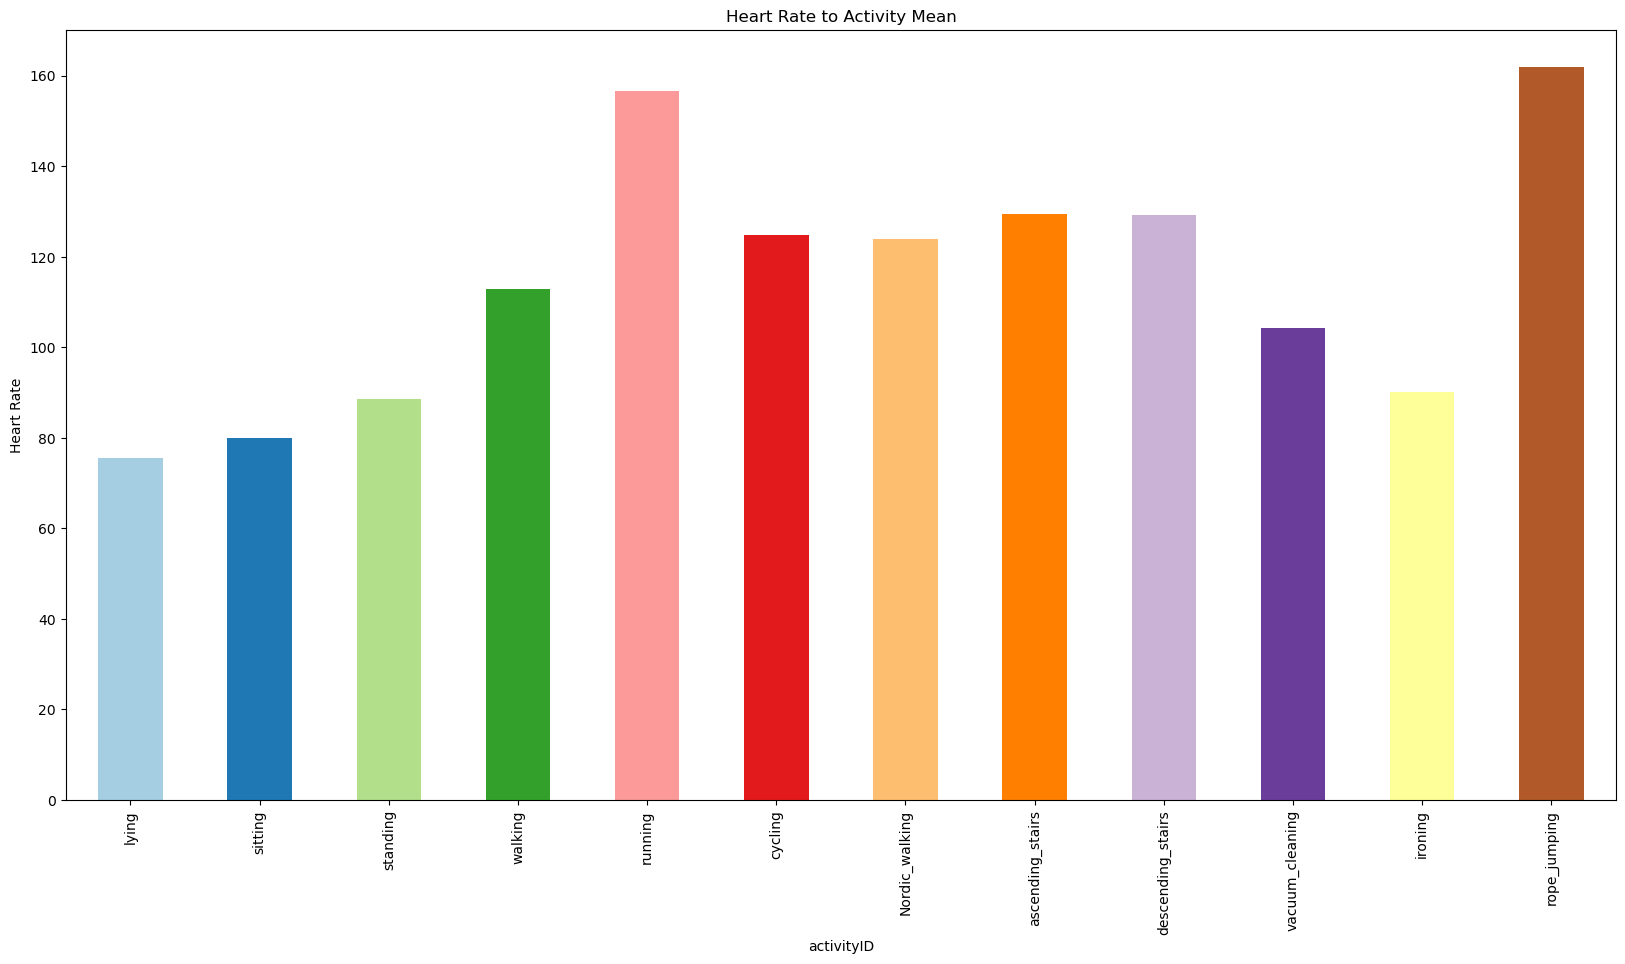

In [15]:
plt.figure()
df_heartrate = data_clean['heartrate'].groupby(data_clean['activityID']).mean()
df_heartrate.index = df_heartrate.index.map(activityIDdict)
plt.title("Heart Rate to Activity Mean")
plt.xlabel("Activity Name")
plt.ylabel("Heart Rate")
df_heartrate.plot(kind='bar',figsize=(20,10), color=plt.cm.Paired(np.arange(N)))
plt.show()

We can clearly see that activities that requires more physical endurance, such as running or rope jumping leads to a higher heart rate.<br>
while activities likes sitting or lying leads to a lower heart rate.

## Additional preprocessing of the data
---

As it can be seen from the description above the data is vastly compromized on big numbers, for example heart rate of 202.<br> In order to reduce computation time we will use a scaler to scale the data, from various attemps we concluded that the best scaler is **RobustScaler**, probably due to the outliers which is the disconnections in the wireless sensors.<br><br>
Also note that there is no need for the subjectID or the timestamps since we preprocessed our data to perform as a data for a supervised learning model, we are only interested in predicting the activityID

In [ ]:
# data scaling helper functions
def scale_data(train_data,test_data,features):
    from sklearn.preprocessing import RobustScaler
    
    scaler = RobustScaler()
    train_data = train_data.copy()
    test_data = test_data.copy()
    
    scaler = scaler.fit(train_data[features])
    train_data.loc[:,features] = scaler.transform(train_data[features].to_numpy())
    test_data.loc[:,features] = scaler.transform(test_data[features].to_numpy())
    return train_data, test_data

def get_features_for_scale(test_list, remove_list):
    res = [i for i in test_list if i not in remove_list]
    return res

## Creating test and train data
---
### We decided to go with the following testing strategy: since subject 7 and 8 performed most of the tasks they will be a good subjects to use as our test data.<br> So our data will be splitted in the following manner:
* #### train_data: subjects 1-6,9
* #### test_data: subjects 7-8

In [19]:
print(sorted(data_clean['subject_id'].unique()))


[101, 102, 103, 104, 105, 106, 107, 108, 109]


In [20]:
def get_test_data(data_clean):
    return data_clean[data_clean["subject_id"].isin([107, 108])]

def get_train_data(data_clean):
    return data_clean[~data_clean["subject_id"].isin([107, 108])]


In [21]:
print("data_clean shape:" + str(data_clean.shape))
test_data = get_test_data(data_clean)
print("test_data shape: " + str(test_data.shape))

train_data = get_train_data(data_clean)
print("train_data shape: " + str(train_data.shape))

data_clean shape:(1942872, 55)
test_data shape: (494878, 55)
train_data shape: (1447994, 55)


In [22]:
#dropping subject_id and timestamp as these cols arent useful for activity classifications and would add noise
test_data = test_data.drop(["subject_id","timestamp"], axis=1)
train_data = train_data.drop(["subject_id", "timestamp"], axis=1)

In [23]:
#getting the list of features except the target- sctivity id
features_for_scale = get_features_for_scale(list(train_data.columns),['activityID'])

In [ ]:
#so here we are scaling features cleanly and separately for train/test
train_sc, test_sc = scale_data(train_data,test_data,features_for_scale)
print("scaled train data:")
display(train_sc.head(5))
print("scaled test data:")
display(test_sc.head(5))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


scaled train data:


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,...,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4
0,1,-0.162162,-1.153846,0.923842,0.835302,0.393509,0.920158,0.887776,0.377977,-0.000004,...,0.000882,-0.100703,0.010225,-1.087132,-1.158523,-2.727711,1.526042,0.0,-0.45896,0.0
1,1,-0.162162,-1.153846,0.933157,0.709495,0.424143,0.923424,0.803062,0.381055,-0.218473,...,0.054267,0.029434,0.017457,-1.078163,-1.141322,-2.727572,1.526042,0.0,-0.45896,0.0
2,1,-0.162162,-1.153846,0.933029,0.599415,0.439495,0.922929,0.702714,0.381261,-0.305530,...,-0.112877,-0.212901,-0.001051,-1.055340,-1.124387,-2.736134,1.526042,0.0,-0.45896,0.0
3,1,-0.162162,-1.153846,0.924170,0.599674,0.454287,0.917100,0.618129,0.398912,-0.246216,...,-0.104327,-0.060424,0.053052,-1.072902,-1.166088,-2.710688,1.526042,0.0,-0.45896,0.0
4,1,-0.162162,-1.153846,0.934263,0.623521,0.491968,0.915327,0.615029,0.413479,-0.085334,...,-0.003742,-0.196809,-0.003507,-1.049677,-1.166711,-2.710855,1.526042,0.0,-0.45896,0.0


scaled test data:


,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,...,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4
1441603,1,0.445946,-1.230769,-0.514358,-0.327237,-0.515217,-0.505071,-0.324969,-0.560652,0.021418,...,0.012538,-0.037415,0.049292,-0.796644,-1.353739,-0.758182,0.393871,-0.368908,0.731710,-0.366594
1441604,1,0.216216,-1.230769,-0.515040,-0.335388,-0.545220,-0.508770,-0.321796,-0.569387,0.025046,...,-0.000053,-0.033200,0.043932,-0.786353,-1.346001,-0.763091,0.394152,-0.368728,0.731818,-0.366578
1441605,1,-0.013514,-1.230769,-0.477686,-0.304172,-0.521912,-0.512392,-0.302943,-0.578155,0.032087,...,-0.064492,0.157709,0.017728,-0.774754,-1.366709,-0.728519,0.394377,-0.368753,0.731633,-0.366597
1441606,1,-0.243243,-1.230769,-0.482473,-0.312056,-0.529505,-0.510526,-0.302961,-0.572335,0.040904,...,0.079414,0.135858,0.043306,-0.785724,-1.349992,-0.723643,0.394276,-0.368799,0.731421,-0.366810
1441607,1,-0.472973,-1.230769,-0.487261,-0.319937,-0.537098,-0.503036,-0.293623,-0.551984,0.008211,...,-0.023939,-0.192302,-0.012894,-0.785546,-1.354056,-0.718707,0.393927,-0.369012,0.731485,-0.366639


In [25]:
# getting X,y values for train and test set
#ie this takes the scaled training dataframe (train_sc) and splits it into- X_train(input features) and y_train(target=activityid) 
X_train = train_sc.drop('activityID', axis=1).values
y_train = train_sc['activityID'].values

X_test = test_sc.drop('activityID', axis=1).values
y_test = test_sc['activityID'].values

# Building Our First Model

In [ ]:
# visualizations helper functions
def plot_accuracy_vs_loss(history):

  fig, ax = plt.subplots(1,2,figsize=(12,4))
  ax[0].plot(history.history['accuracy'])
  ax[0].plot(history.history['val_accuracy'])
  ax[0].set_title('Model accuracy')
  ax[0].set_ylabel('Accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['Train', 'Test'], loc='upper left')

  # Plot training & validation loss values
  ax[1].plot(history.history['loss'])
  ax[1].plot(history.history['val_loss'])
  ax[1].set_title('Model loss')
  ax[1].set_ylabel('Loss')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['Train', 'Test'], loc='upper left')
  plt.show()

def plot_confusion_matrix(model,X_test,y_test,title='',is_ml=False, labels={}):
    
  ticks = list(map(lambda x : activityIDdict[x], np.unique(y_test).tolist())) if labels=={} else labels.values()
  preds = model.predict(X_test)
  pred_cat = preds if is_ml else np.argmax(preds,axis=1)
  print('model accuracy on test set is: {0:.2f}%'.format(accuracy_score(y_test,pred_cat)*100))
  plt.figure(figsize=(15,8),dpi=120)
  sns.heatmap(confusion_matrix(y_test,pred_cat),cmap='Blues',annot=True, fmt='d',xticklabels=ticks,yticklabels=ticks)
  plt.xlabel('Prediction')
  plt.ylabel('True label')
  plt.title(title)
  plt.show()

## building a naive model

### We will start by building a first naive or baseline model.<br>We will the standart deviation of the features and then fit a simple classic ML model.<br>We will then predict on the real train and test set in order to get a simple base results

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score

# # X_train and y_train come from full scaled dataset
# model = LogisticRegression(max_iter=200)
# model.fit(X_train, y_train)

# # Predict on train and test
# y_pred_train = model.predict(X_train)
# y_pred_test = model.predict(X_test)

# # Accuracy
# print("Model accuracy on train set is: {:.2f}%".format(accuracy_score(y_train, y_pred_train) * 100))
# print("Model accuracy on test set is: {:.2f}%".format(accuracy_score(y_test, y_pred_test) * 100))


In [ ]:
# train_act = train_sc.groupby(data_clean['activityID'])
# X_train_base = train_act.std().drop('activityID', axis=1).values
# y_train_base = np.array(train_act['activityID'].unique().explode().values).astype('float64')

In [116]:
# # using logistic regression as our estimator for the naive model
# logreg = LogisticRegression(max_iter=200)
# logreg.fit(X_train_base, y_train_base)

In [117]:
# y_pred_train = logreg.predict(X_train)
# print('model accuracy on train set is: {0:.2f}%'.format(accuracy_score(y_train,y_pred_train)*100))
# y_pred_test = logreg.predict(X_test)
# print('model accuracy on test set is: {0:.2f}%'.format(accuracy_score(y_test,y_pred_test)*100))

<!-- ### As we can see the result are very low on both the training and test set, next we will try to better our model using another classic ML algorithm. -->

##  Feature Importance using Decision Tree

To understand which features contribute most to activity classification, we use a `DecisionTreeClassifier` to calculate feature importances.

We then:
- Extract and sort feature importances.
- Visualize the top 10 most important features.

This helps in selecting the most relevant sensors for building efficient models like LSTM.


In [127]:
from sklearn.tree import DecisionTreeClassifier
X_train = train_sc.drop('activityID', axis=1).values
y_train = train_sc['activityID'].values

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)


DecisionTreeClassifier()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

feature_names = train_sc.drop('activityID', axis=1).columns
importances = clf.feature_importances_ #built in

#combining into a DataFrame and sort
imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
imp_df = imp_df.sort_values(by='importance', ascending=False)

#show
print(imp_df.head(10))


             feature  importance
35  ankleTemperature    0.150302
0          heartrate    0.149007
18  chestTemperature    0.117045
24       chestAcc6_3    0.102496
1    handTemperature    0.100392
47       ankleMagne3    0.062607
21      chestAcc16_3    0.058706
11        handMagne1    0.046617
2        handAcc16_1    0.044712
29       chestMagne2    0.023525


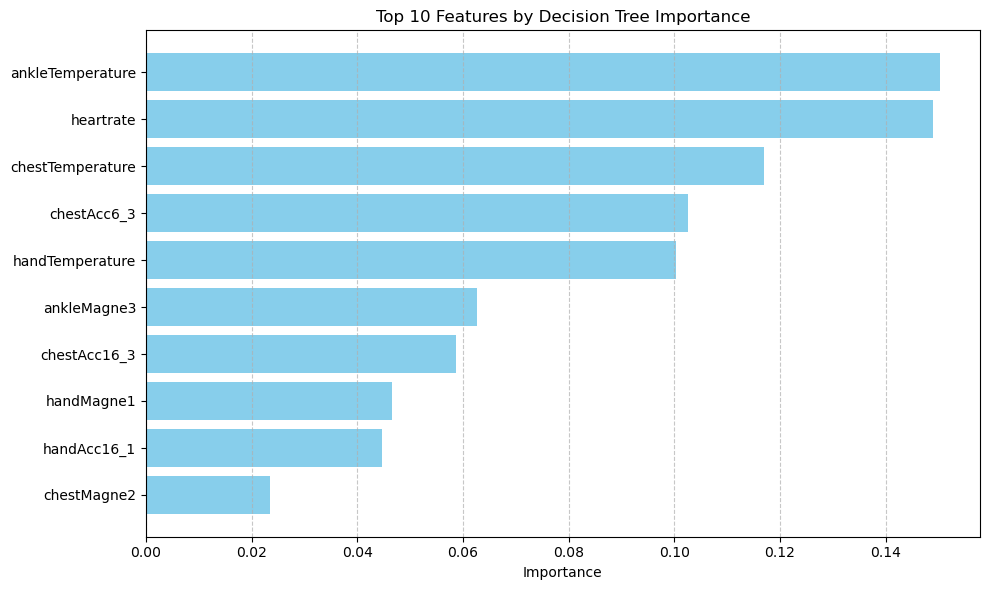

In [129]:
# Plot top 10 important features
plt.figure(figsize=(10, 6))
plt.barh(imp_df['feature'].head(10), imp_df['importance'].head(10), color='skyblue')
plt.xlabel("Importance")
plt.title("Top 10 Features by Decision Tree Importance")
plt.gca().invert_yaxis()  # Highest on top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [130]:
top_features = imp_df['feature'].head(25).tolist()
top_features.append('activityID')


In [131]:
train_dt_top = train_sc[top_features]
test_dt_top = test_sc[top_features]

X_train_dt_top = train_dt_top.drop('activityID', axis=1)
y_train_dt_top = train_dt_top['activityID']

X_test_dt_top = test_dt_top.drop('activityID', axis=1)
y_test_dt_top = test_dt_top['activityID']


In [132]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf_top = DecisionTreeClassifier(random_state=42)
clf_top.fit(X_train_dt_top, y_train_dt_top)

# y_pred_top = clf_top.predict(X_test_dt_top)
# acc_top = accuracy_score(y_test_dt_top, y_pred_top)


DecisionTreeClassifier(random_state=42)

model accuracy on test set is: 44.51%


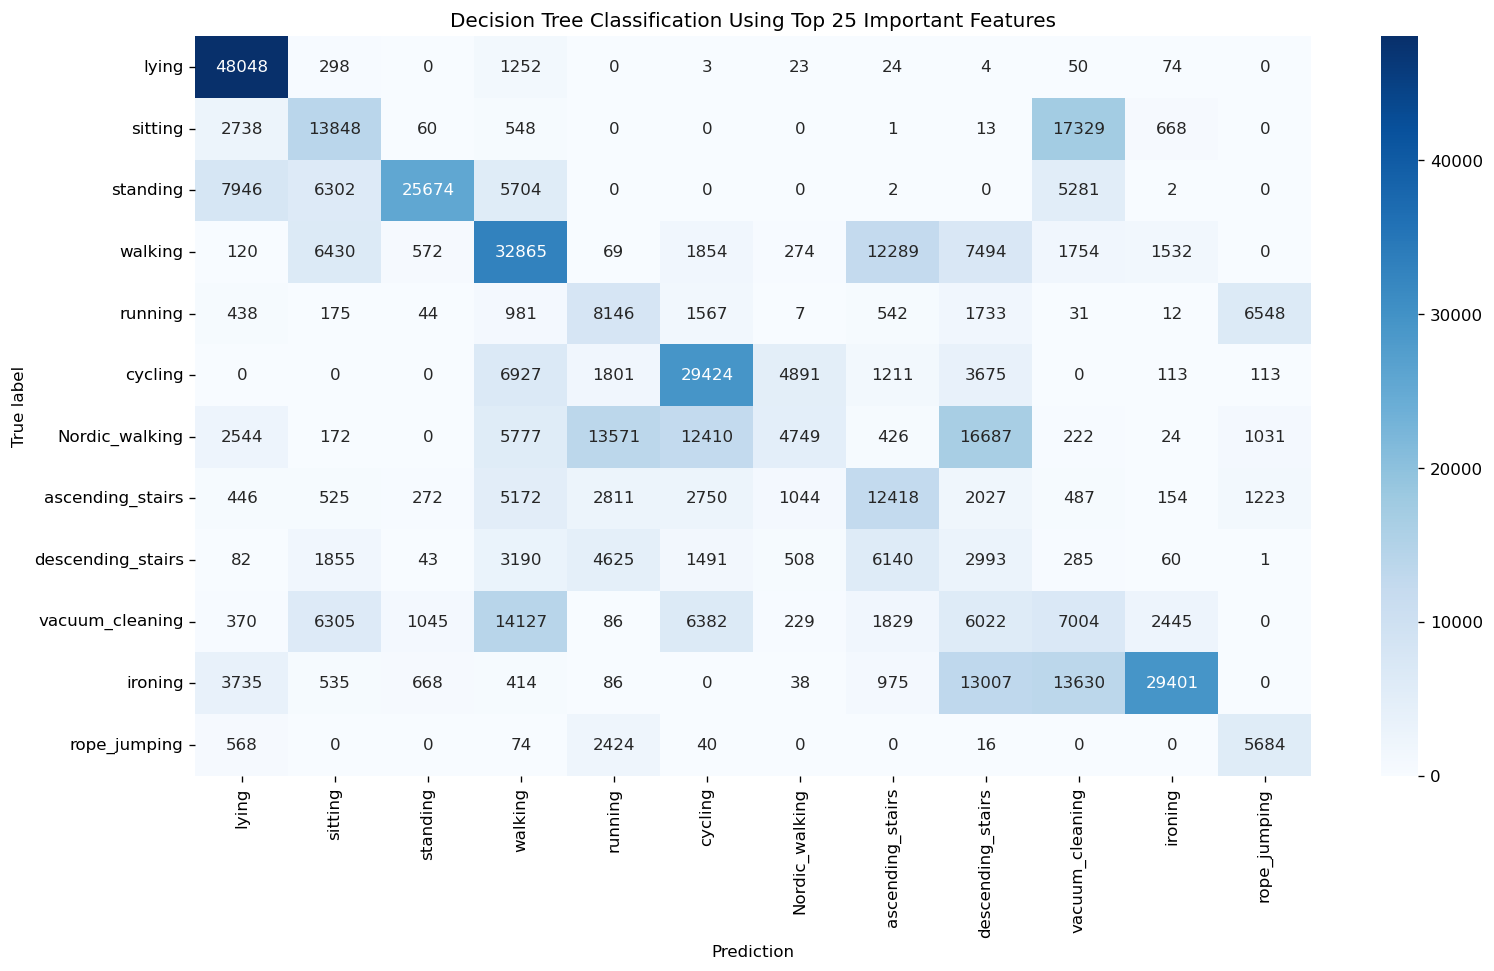

In [133]:
plot_confusion_matrix(
    clf_top,
    X_test_dt_top,
    y_test_dt_top,
    title="Decision Tree Classification Using Top 25 Important Features",
    is_ml=True
)

model accuracy on test set is: 43.98%


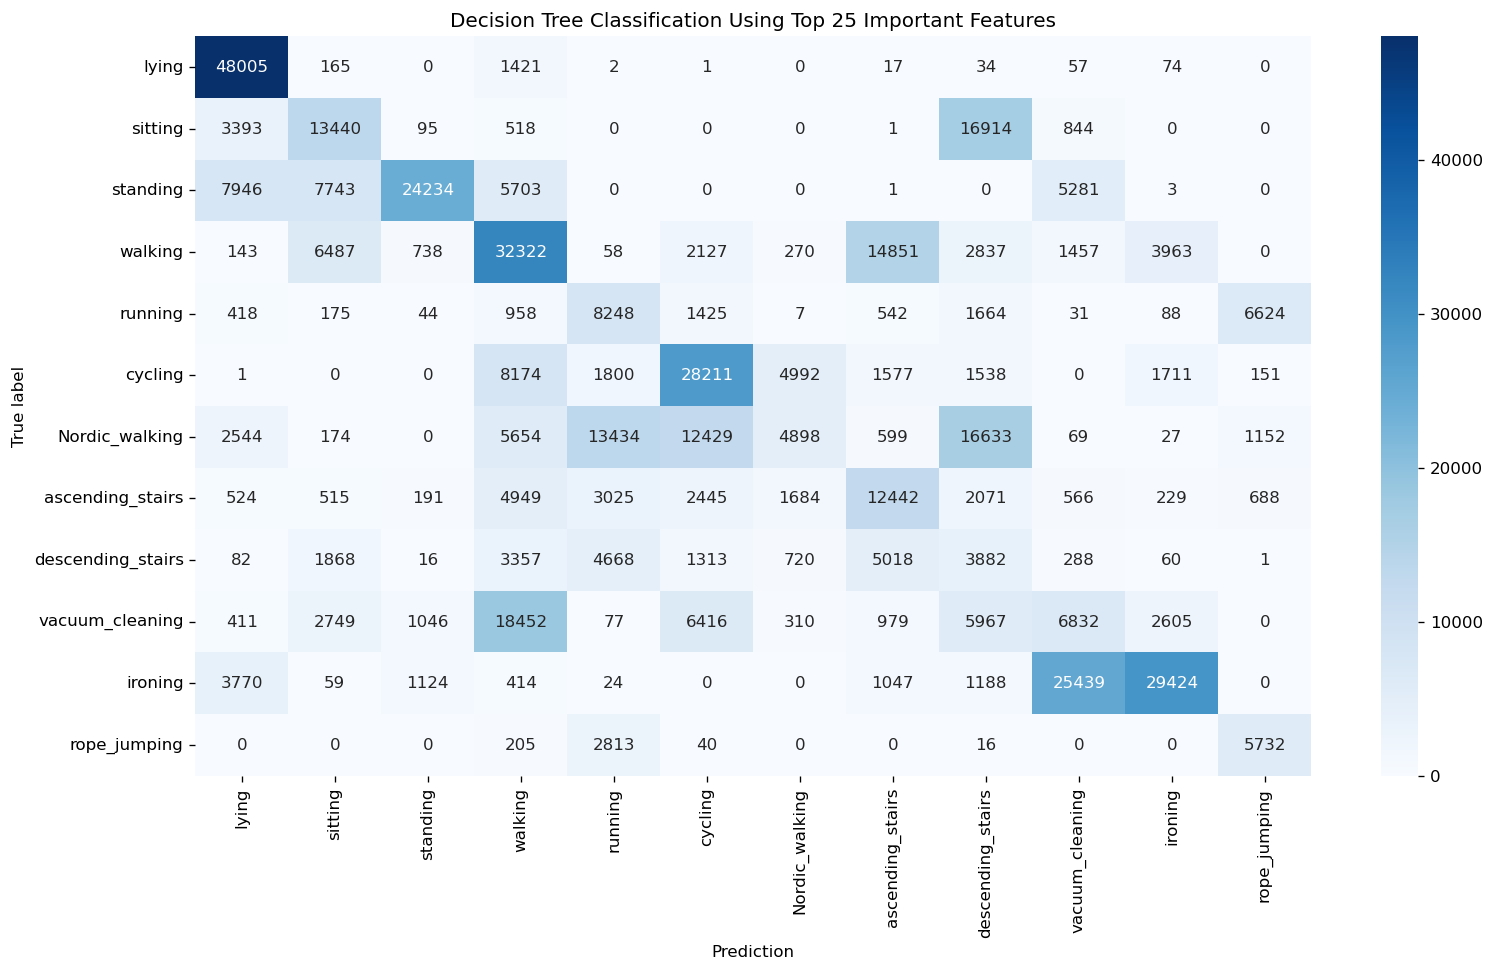

In [58]:
plot_confusion_matrix(
    clf_top,
    X_test_dt_top,
    y_test_dt_top,
    title="Decision Tree Classification Using Top 25 Important Features",
    is_ml=True
)

#### We can see that the model accuracy on the test set is around 43% 

## Building our second model - LSTM

#### since our data compromized on time-series we will use the notion of Deep Neural Network with LSTM embedding.<br> We will start with a simple LSTM model and based on the result will lean toward better models with a greater accuracy.

### Data preprocessing

#### We will start by creating a dataset based on sliding window as shown in class.<br><br>The *timesteps* represents the samples we want to sample in a batch.<br> The *steps* represents the stride of the window.

In [135]:
top_features = imp_df['feature'].head(25).tolist()  


In [136]:
df_train_X = train_sc[top_features]
df_train_y = train_sc['activityID']

df_test_X = test_sc[top_features]
df_test_y = test_sc['activityID']


In [ ]:
#(total rows-timestep)/step-> how many lstm ready samples from the total rows.

In [137]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels, keepdims=True).mode[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)


In [ ]:
TIME_STEPS = 6 #each seq will include 6 time steps
STEP = 2 #the window moves 2 rows forward for the next sample

X_train_lstm, y_train_lstm = create_dataset(df_train_X, df_train_y, time_steps=TIME_STEPS, step=STEP)
X_test_lstm, y_test_lstm = create_dataset(df_test_X, df_test_y, time_steps=TIME_STEPS, step=STEP)


In [ ]:
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
enc.fit(y_train_lstm)

y_train_lstm = enc.transform(y_train_lstm)
y_test_lstm = enc.transform(y_test_lstm)


### creating the model:

In [68]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(y_train_lstm.shape[1], activation='softmax'))

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

hist_lstm = lstm_model.fit(X_train_lstm, y_train_lstm, validation_split=0.2,
                           epochs=6, batch_size=128, shuffle=False, verbose=1)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/6
4525/4525 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7038 - loss: 1.0729 - val_accuracy: 0.2603 - val_loss: 4.0589
Epoch 2/6
4525/4525 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7923 - loss: 0.6441 - val_accuracy: 0.2499 - val_loss: 4.4573
Epoch 3/6
4525/4525 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8090 - loss: 0.5827 - val_accuracy: 0.3520 - val_loss: 3.7841
Epoch 4/6
4525/4525 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8360 - loss: 0.4894 - val_accuracy: 0.3680 - val_loss: 4.1972
Epoch 5/6
4525/4525 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8617 - loss: 0.4132 - val_accuracy: 0.4381 - val_loss: 4.1647
Epoch 6/6
4525/4525 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8785 - loss: 0.3515 - val_accuracy: 0.4236 - val_loss: 4.4610


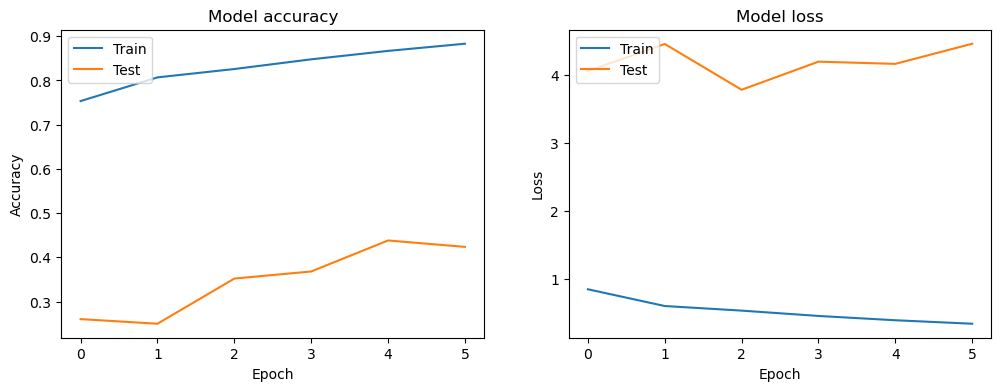

In [69]:
plot_accuracy_vs_loss(hist_lstm)


In [141]:
def map_one_hot_enc_positions_and_labels(model, X_test, y_test):
    preds = model.predict(X_test)
    preds = np.argmax(preds, axis=1)
    indicies = np.unique(preds).tolist()
    actual = np.unique(y_test).tolist()
    
    zipped = list(zip(actual, indicies))
    idx_dict = dict(zipped)
    y_test_e = [idx_dict[act[0]] for act in y_test.tolist()]
    
    labelsDict = {idx: activityIDdict[act] for (act, idx) in zipped}
    return np.array(y_test_e), labelsDict


7733/7733 ━━━━━━━━━━━━━━━━━━━━ 3s 417us/step
7733/7733 ━━━━━━━━━━━━━━━━━━━━ 3s 403us/step
model accuracy on test set is: 40.56%


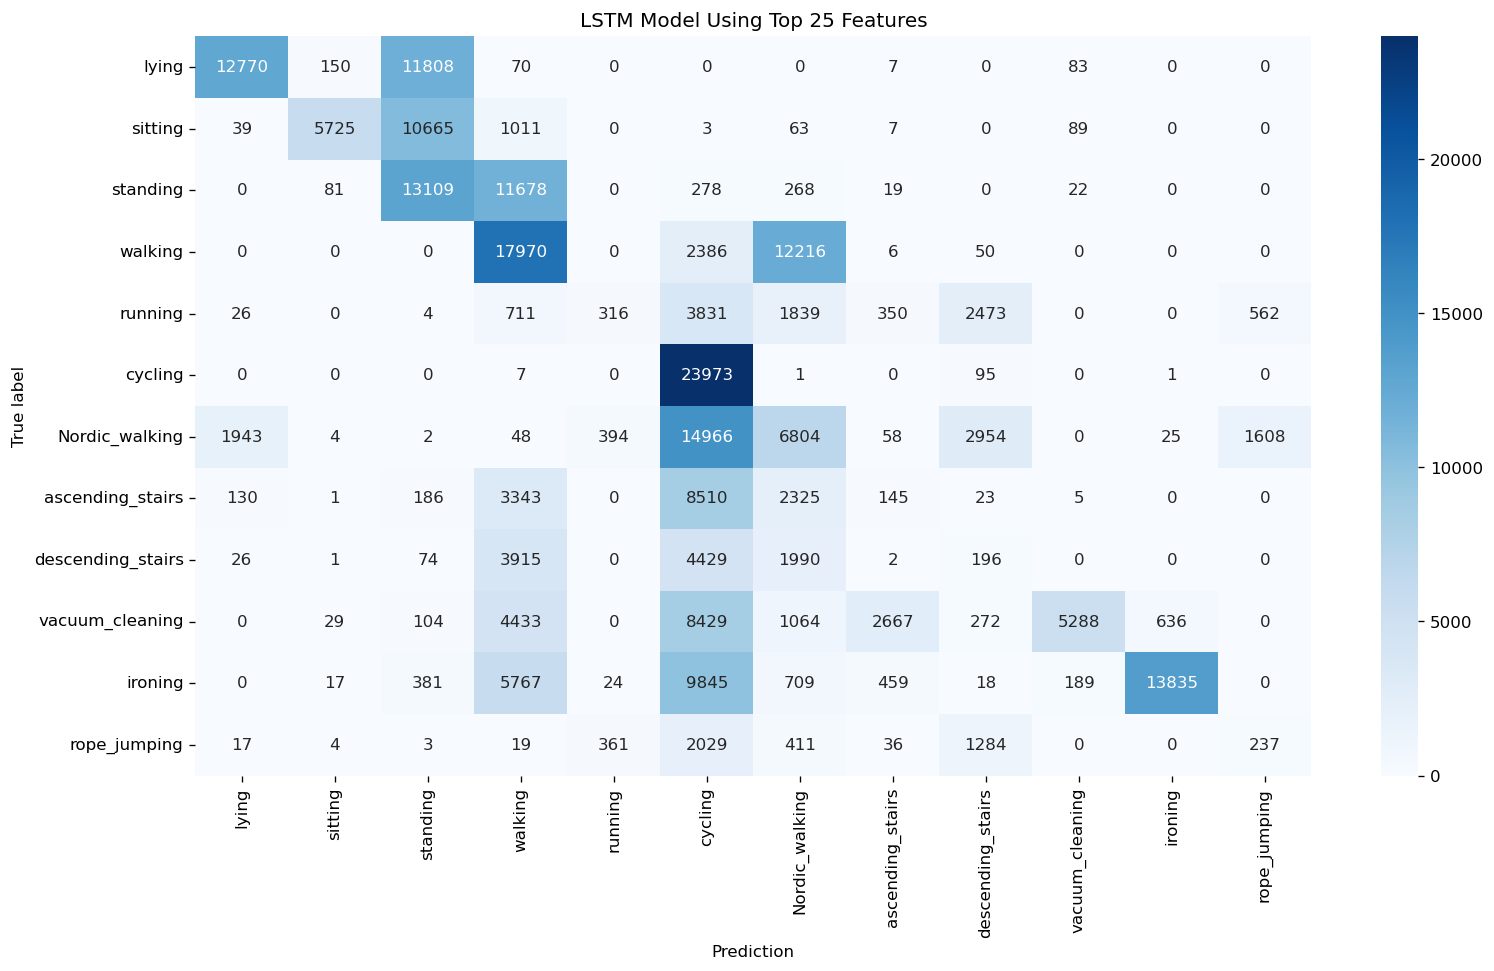

In [71]:
y_original = enc.inverse_transform(y_test_lstm)
y, labels = map_one_hot_enc_positions_and_labels(lstm_model, X_test_lstm, y_original)

plot_confusion_matrix(
    lstm_model,
    X_test_lstm,
    y,
    title="LSTM Model Using Top 25 Features",
    labels=labels
)


### trying to Reduce Model Complexity

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Define a lighter LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(32, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))  #reduced from 64
lstm_model.add(Dropout(0.4))  # more regularization
lstm_model.add(Dense(16, activation='relu'))  # smaller dense layer
lstm_model.add(Dense(y_train_lstm.shape[1], activation='softmax'))

# Compile the model
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary
lstm_model.summary()

# Train the model
np.random.seed(2018)
hist_lstm = lstm_model.fit(
    X_train_lstm,
    y_train_lstm,
    validation_split=0.2,
    epochs=6,
    batch_size=128,
    shuffle=False,
    verbose=1
)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │         7,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,156 (31.86 KB)

 Trainable params: 8,156 (31.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
4525/4525 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.6278 - loss: 1.3298 - val_accuracy: 0.1737 - val_loss: 4.6487
Epoch 2/6
4525/4525 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7379 - loss: 0.8565 - val_accuracy: 0.3037 - val_loss: 3.7693
Epoch 3/6
4525/4525 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7899 - loss: 0.6272 - val_accuracy: 0.4837 - val_loss: 3.5135
Epoch 4/6
4525/4525 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8095 - loss: 0.5528 - val_accuracy: 0.5010 - val_loss: 3.4970
Epoch 5/6
4525/4525 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8275 - loss: 0.4961 - val_accuracy: 0.4949 - val_loss: 3.5618
Epoch 6/6
4525/4525 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.8491 - loss: 0.4331 - val_accuracy: 0.4900 - val_loss: 3.8726


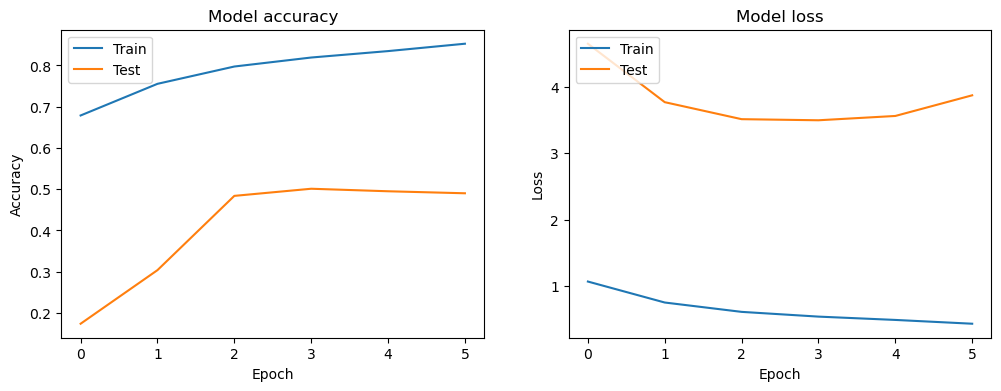

In [ ]:
plot_accuracy_vs_loss(hist_lstm) 


7733/7733 ━━━━━━━━━━━━━━━━━━━━ 2s 311us/step
7733/7733 ━━━━━━━━━━━━━━━━━━━━ 2s 306us/step
model accuracy on test set is: 44.24%


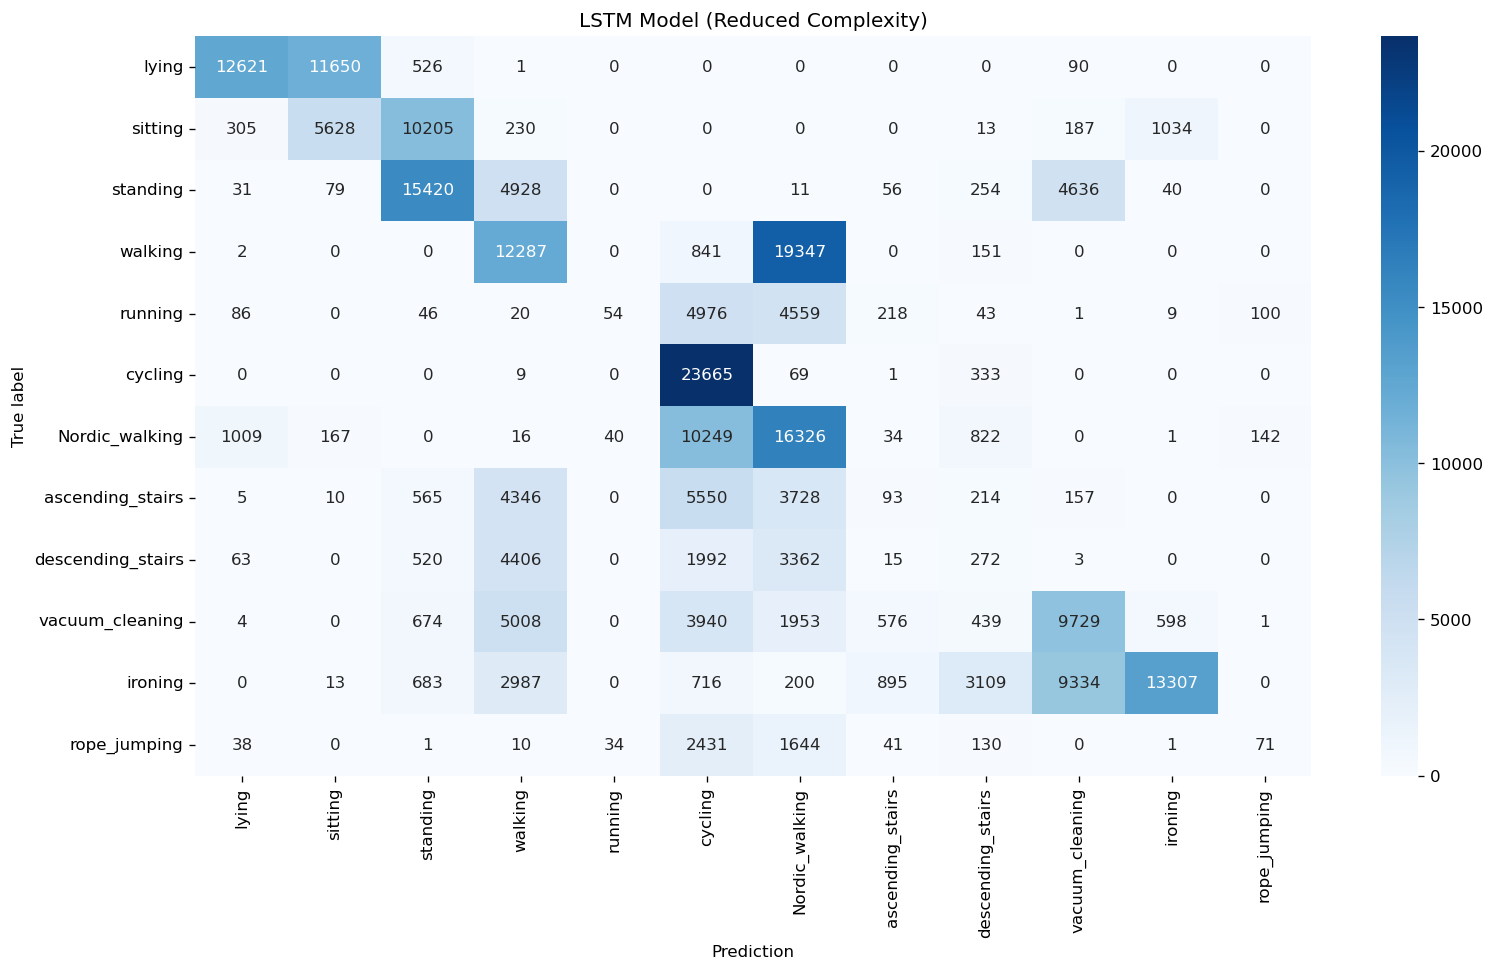

In [79]:
y = enc.inverse_transform(y_test_lstm)
y, labels = map_one_hot_enc_positions_and_labels(lstm_model, X_test_lstm, y)

plot_confusion_matrix(
    lstm_model,
    X_test_lstm,
    y,
    title="LSTM Model (Reduced Complexity)",
    labels=labels
)


In [ ]:
lstm_model.save("reduced_lstm_model.h5")


good reporting required! in the notebook

### trying with earlystopping:

In [80]:
from keras.callbacks import EarlyStopping
# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(32, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(16, activation='relu'))
lstm_model.add(Dense(y_train_lstm.shape[1], activation='softmax'))

# Compile the model
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# EarlyStopping setup
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# Train the model
np.random.seed(2018)
hist_lstm = lstm_model.fit(
    X_train_lstm,
    y_train_lstm,
    validation_split=0.2,
    epochs=20,
    batch_size=128,
    shuffle=False,
    verbose=1,
    callbacks=[early_stop]
)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
4525/4525 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.6053 - loss: 1.3353 - val_accuracy: 0.2519 - val_loss: 3.6704
Epoch 2/20
4525/4525 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7591 - loss: 0.7677 - val_accuracy: 0.3261 - val_loss: 3.5344
Epoch 3/20
4525/4525 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7984 - loss: 0.6120 - val_accuracy: 0.4080 - val_loss: 3.4926
Epoch 4/20
4525/4525 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8232 - loss: 0.5255 - val_accuracy: 0.4206 - val_loss: 3.6189
Epoch 5/20
4525/4525 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.8443 - loss: 0.4553 - val_accuracy: 0.4278 - val_loss: 3.6394


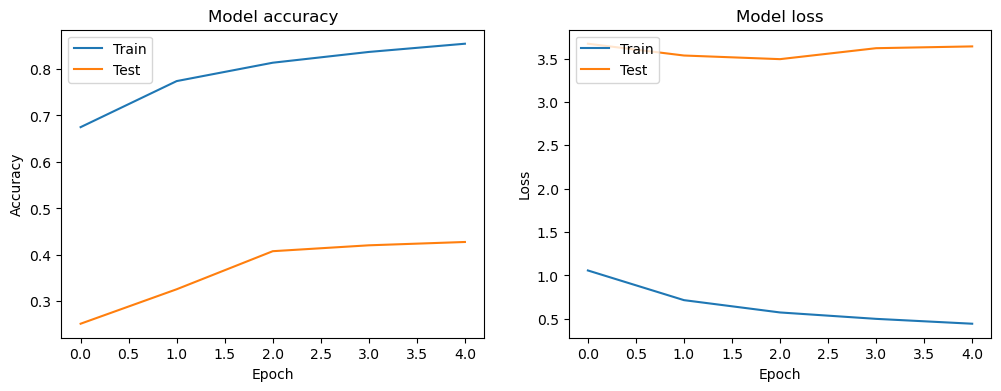

In [81]:
plot_accuracy_vs_loss(hist_lstm)


7733/7733 ━━━━━━━━━━━━━━━━━━━━ 3s 325us/step
7733/7733 ━━━━━━━━━━━━━━━━━━━━ 2s 320us/step
model accuracy on test set is: 44.19%


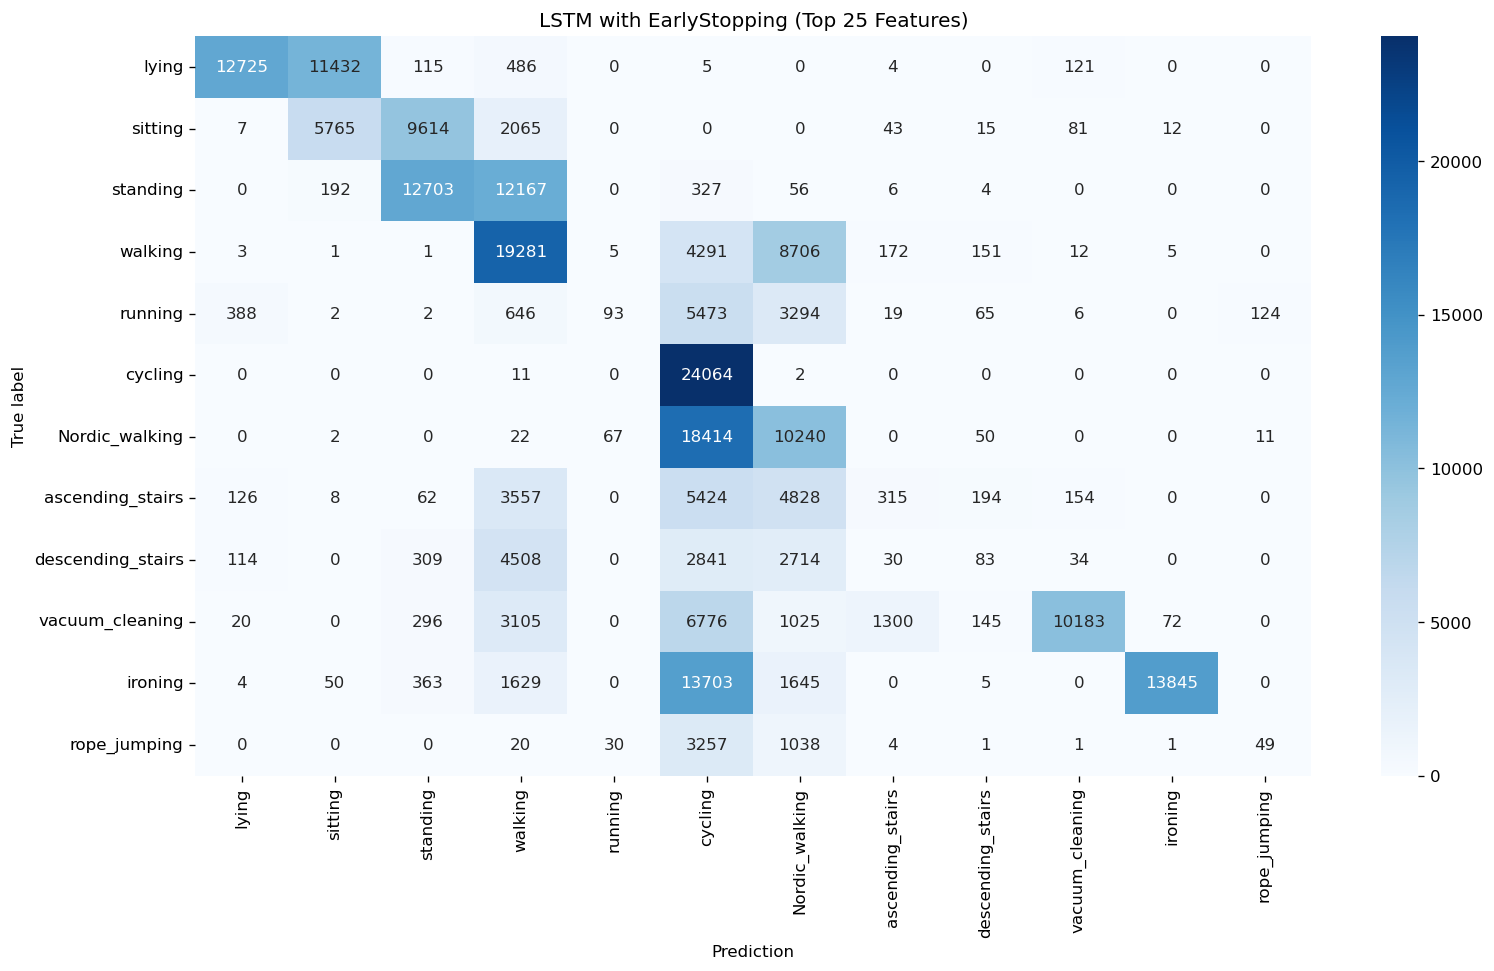

In [82]:
y_original = enc.inverse_transform(y_test_lstm)
y, labels = map_one_hot_enc_positions_and_labels(lstm_model, X_test_lstm, y_original)

plot_confusion_matrix(
    lstm_model,
    X_test_lstm,
    y,
    title="LSTM with EarlyStopping (Top 25 Features)",
    labels=labels
)


simple lstm->40.56
reduce complexity->44.24
early stop->44.19

### trying Bidirectional LSTM:

In [ ]:
# Define a Bidirectional LSTM model
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(32), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
bilstm_model.add(Dropout(0.4))
bilstm_model.add(Dense(16, activation='relu'))
bilstm_model.add(Dense(y_train_lstm.shape[1], activation='softmax'))

# Compile the model
bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary
bilstm_model.summary()

#Train the model
np.random.seed(2018)
hist_bilstm = bilstm_model.fit(
    X_train_lstm,
    y_train_lstm,
    validation_split=0.2,
    epochs=6,
    batch_size=128,
    shuffle=False,
    verbose=1
)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 64)             │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 12)             │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,092 (62.86 KB)

 Trainable params: 16,092 (62.86 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
4525/4525 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6710 - loss: 1.1904 - val_accuracy: 0.1597 - val_loss: 3.9433
Epoch 2/6
4525/4525 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.7631 - loss: 0.7426 - val_accuracy: 0.2876 - val_loss: 3.3620
Epoch 3/6
4525/4525 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7922 - loss: 0.6470 - val_accuracy: 0.4736 - val_loss: 3.5453
Epoch 4/6
4525/4525 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8295 - loss: 0.5051 - val_accuracy: 0.4724 - val_loss: 3.9779
Epoch 5/6
4525/4525 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8584 - loss: 0.4165 - val_accuracy: 0.5141 - val_loss: 4.1072
Epoch 6/6
4525/4525 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8748 - loss: 0.3686 - val_accuracy: 0.5371 - val_loss: 4.0112


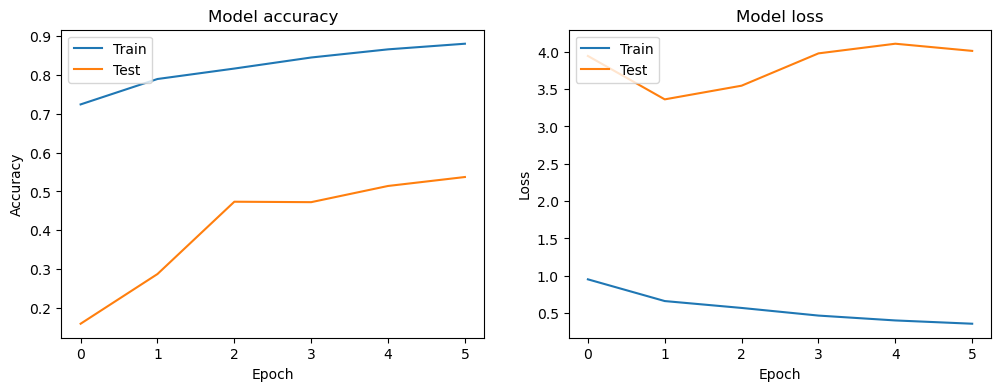

In [91]:
plot_accuracy_vs_loss(hist_bilstm)


7733/7733 ━━━━━━━━━━━━━━━━━━━━ 4s 453us/step
7733/7733 ━━━━━━━━━━━━━━━━━━━━ 4s 467us/step
model accuracy on test set is: 42.32%


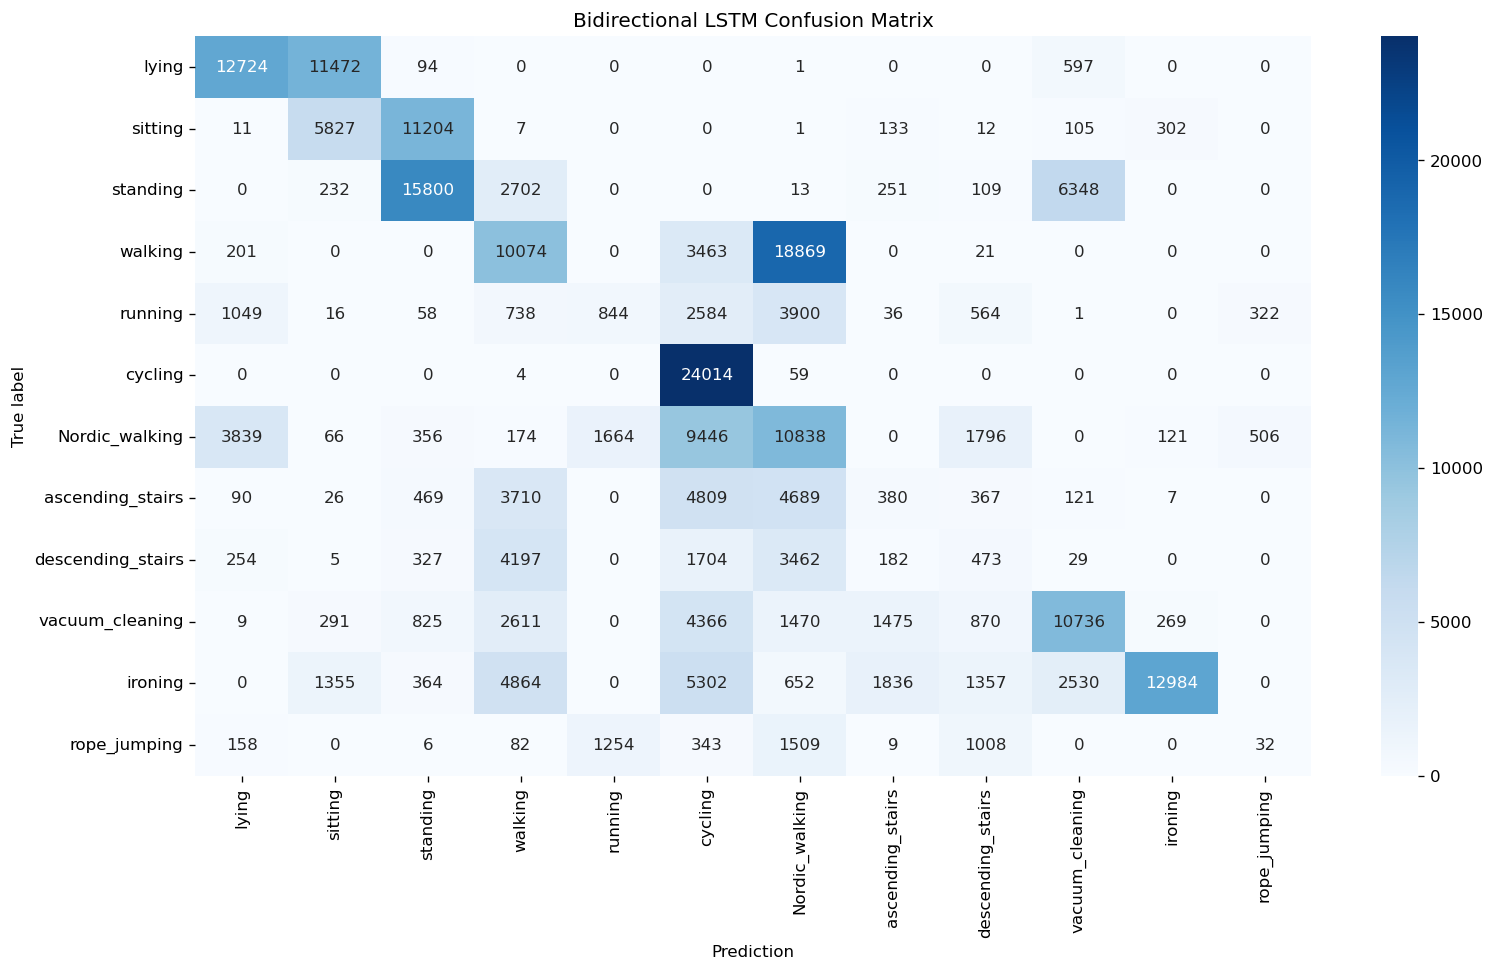

In [92]:
y_original_bilstm = enc.inverse_transform(y_test_lstm)
y_bilstm, labels_bilstm = map_one_hot_enc_positions_and_labels(
    bilstm_model,
    X_test_lstm,
    y_original_bilstm
)
plot_confusion_matrix(
    bilstm_model,
    X_test_lstm,
    y_bilstm,
    title="Bidirectional LSTM Confusion Matrix",
    labels=labels_bilstm
)

### trying with enlarging timsteps and steps

In [ ]:
# TIME_STEPS = 20
# STEPS = 5
